Autores: Alexandre Liermann, Gustavo Guerreiro e João Martinho.

# Implementação de Classificação de Imagens de Ressonância Magnética para Diagnóstico de Alzheimer Usando CNN em TensorFlow

Importações das bibliotecas necessárias

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
os.environ['TF_CUDNN_BENCHMARK'] = 'false'

import gc
import glob
import pathlib
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
from tensorflow.data import AUTOTUNE
from sklearn.utils import class_weight
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras import models, layers, mixed_precision, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


Definindo constantes a serem usadas

In [2]:
IMG_ALTURA    = 176
IMG_LARGURA   = 208
TAMANHO_BATCH = 64

SEED = 2025

In [3]:
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

print('Seed global definida:', SEED)

Seed global definida: 2025


In [4]:
def configurar_gpu():
    try:
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"Erro ao configurar GPU: {e}")

mixed_precision.set_global_policy('mixed_float16')
configurar_gpu()

Definindo os diretórios do dataset

In [5]:
dir_dados = pathlib.Path('dataset')

caminhos_arquivos = []
rotulos = []
nomes_classes = sorted([item.name for item in dir_dados.glob('*') if item.is_dir()])
dict_classes = {nome: i for i, nome in enumerate(nomes_classes)}

for nome_classe in nomes_classes:
    padrao = str(dir_dados / nome_classe / '*')
    arquivos = glob.glob(padrao)
    caminhos_arquivos.extend(arquivos)
    rotulos.extend([dict_classes[nome_classe]] * len(arquivos))

caminhos_arquivos = np.array(caminhos_arquivos)
rotulos = np.array(rotulos)

X_restante, X_teste, y_restante, y_teste = train_test_split(
    caminhos_arquivos, rotulos, test_size=0.15, stratify=rotulos, random_state=SEED
)

print(f"Total para K-Fold (Treino+Val): {len(X_restante)}")
print(f"Reservado para Teste Final: {len(X_teste)}")

def processar_arquivo(caminho, rotulo):
    arquivo = tf.io.read_file(caminho)
    img = tf.io.decode_image(arquivo, channels=1, expand_animations=False)
    img = tf.image.resize(img, [IMG_ALTURA, IMG_LARGURA])
    img = tf.cast(img, tf.float32)
    return img, rotulo

def criar_dataset_fold(caminhos, labels_fold, training=True):
    ds = tf.data.Dataset.from_tensor_slices((caminhos, labels_fold))
    ds = ds.map(processar_arquivo, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.shuffle(len(caminhos), seed=SEED)
    ds = ds.batch(TAMANHO_BATCH)
    ds = ds.prefetch(AUTOTUNE)
    return ds

Total para K-Fold (Treino+Val): 5440
Reservado para Teste Final: 960


Iniciando a configuração do modelo.

In [6]:
@tf.keras.utils.register_keras_serializable()
def converter_para_cinza_gpu(x):
    return tf.image.rgb_to_grayscale(x)

def construir_modelo():
    tf.keras.backend.clear_session()
    gc.collect()

    modelo = models.Sequential([
        layers.Input(shape=(IMG_ALTURA, IMG_LARGURA, 1)),

        layers.Conv2D(32, (3, 3), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(64, (3, 3), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(128, (3, 3), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(256, (3, 3), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Flatten(),
        layers.Dense(512, use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),
        layers.Dense(4, activation='softmax')
    ])

    opt = optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)
    modelo.compile(
        optimizer=opt,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return modelo

Definindo callback de EarlyStopping.

In [7]:
def obter_callbacks(caminho_modelo):
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )

    reduce_le = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )

    checkpoint = ModelCheckpoint(
        caminho_modelo,
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=0
    )

    return [early_stop, reduce_le, checkpoint]

Colocando pesos nas classes a fim de diminuir falsos negativos (melhorar Recall).

In [8]:
def ajustar_pesos(rotulos_treino):
    pesos_base = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(rotulos_treino),
        y=rotulos_treino
    )

    pesos_dict = dict(enumerate(pesos_base))
    fator_rigor = 2.5
    indice_saudavel = 2
    for classe, peso in pesos_dict.items():
        if classe != indice_saudavel:
            pesos_dict[classe] = peso * fator_rigor
            if classe == 1:
                 pesos_dict[classe] *= 1.5

    print("Pesos das classes:", pesos_dict)
    return pesos_dict

In [9]:
def avaliar_fold(modelo, ds_val, melhor_acc_atual):
    scores = modelo.evaluate(ds_val, verbose=0)
    acuracia_fold = scores[1]
    loss_fold = scores[0]
    print(f"   > Acurácia Validação: {acuracia_fold*100:.2f}% (Loss: {loss_fold:.4f})")
    nova_melhor_acc = melhor_acc_atual

    if acuracia_fold > melhor_acc_atual:
        nova_melhor_acc = acuracia_fold
        print(f"   > Novo recorde! (Anterior: {melhor_acc_atual*100:.2f}%) -> Salvando modelo...")
        modelo.save('melhor_modelo_kfold.keras')

    return acuracia_fold, nova_melhor_acc

Treinando o modelo

In [10]:
PASTA_FOLDS = "Folds"
os.makedirs(PASTA_FOLDS, exist_ok=True)

NUM_FOLDS = 6
skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED)
resultados_acuracia = []

print(f"Iniciando Treinamento com {NUM_FOLDS} Folds...\n")

fold_atual = 1
for idx_treino, idx_val in skf.split(X_restante, y_restante):
    print(f"--- Rodando Fold {fold_atual}/{NUM_FOLDS} ---")

    X_treino_f, X_val_f = X_restante[idx_treino], X_restante[idx_val]
    y_treino_f, y_val_f = y_restante[idx_treino], y_restante[idx_val]

    ds_treino = criar_dataset_fold(X_treino_f, y_treino_f, training=True)
    ds_val = criar_dataset_fold(X_val_f, y_val_f, training=False)

    pesos = ajustar_pesos(y_treino_f)
    modelo_fold = construir_modelo()

    nome_arquivo = f'modelo_fold_{fold_atual}.keras'
    caminho_modelo = os.path.join(PASTA_FOLDS, nome_arquivo)

    callbacks_list = obter_callbacks(caminho_modelo)

    history = modelo_fold.fit(
        ds_treino,
        validation_data=ds_val,
        epochs=150,
        callbacks=callbacks_list,
        class_weight=pesos
    )

    modelo_fold.load_weights(caminho_modelo)
    scores = modelo_fold.evaluate(ds_val, verbose=0)
    print(f"   > Acurácia Final Fold {fold_atual}: {scores[1]*100:.2f}%")
    resultados_acuracia.append(scores[1])

    del ds_treino, ds_val, modelo_fold
    tf.keras.backend.clear_session()
    gc.collect()

    fold_atual += 1

print("\n" + "="*30)
print(f"Média Final de Acurácia: {np.mean(resultados_acuracia)*100:.2f}%")
print("O melhor modelo de todos os folds já está salvo como 'melhor_modelo_kfold.keras'")

Iniciando Treinamento com 6 Folds...

--- Rodando Fold 1/6 ---


I0000 00:00:1763859955.976989   15925 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Pesos das classes: {0: np.float64(4.461614173228346), 1: np.float64(94.4375), 2: np.float64(0.5001103265666372), 3: np.float64(1.7852079395085065)}
Epoch 1/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 196ms/step - accuracy: 0.5306 - loss: 2.1687 - val_accuracy: 0.6119 - val_loss: 1.1071 - learning_rate: 1.0000e-04
Epoch 2/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 14s 192ms/step - accuracy: 0.8350 - loss: 0.4228 - val_accuracy: 0.7233 - val_loss: 0.7155 - learning_rate: 1.0000e-04
Epoch 3/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 13s 184ms/step - accuracy: 0.9552 - loss: 0.1383 - val_accuracy: 0.8291 - val_loss: 0.4351 - learning_rate: 1.0000e-04
Epoch 4/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 13s 184ms/step - accuracy: 0.9899 - loss: 0.0465 - val_accuracy: 0.9416 - val_loss: 0.1965 - learning_rate: 1.0000e-04
Epoch 5/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 13s 180ms/step - accuracy: 0.9940 - loss: 0.0240 - val_accuracy: 0.9184 - val_loss: 0.2182 - learning_rate: 1.0000e-04
Epoch 6/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 13s 178ms/step - accura

Métricas mais avançadas com sklearn


--- Iniciando Avaliação por Ensemble (Soft Voting) ---
Carregando: Folds/modelo_fold_1.keras
Carregando: Folds/modelo_fold_2.keras
Carregando: Folds/modelo_fold_3.keras
Carregando: Folds/modelo_fold_4.keras
Carregando: Folds/modelo_fold_5.keras
Carregando: Folds/modelo_fold_6.keras

Relatório de Classificação (Ensemble):
              precision    recall  f1-score   support

        Mild       0.99      1.00      1.00       134
         Mod       1.00      1.00      1.00        10
         Non       1.00      1.00      1.00       480
       VMild       1.00      1.00      1.00       336

    accuracy                           1.00       960
   macro avg       1.00      1.00      1.00       960
weighted avg       1.00      1.00      1.00       960



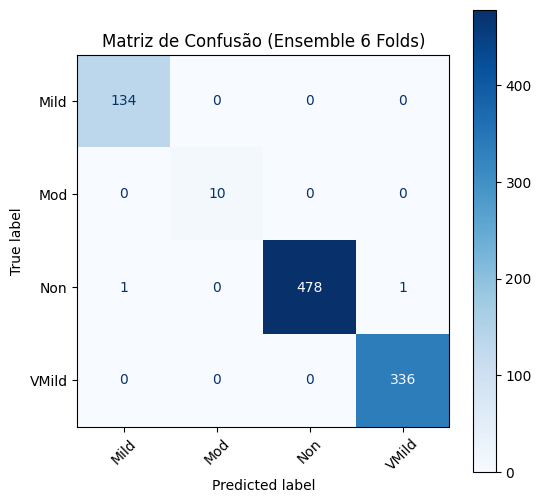

In [11]:
print("\n--- Iniciando Avaliação por Ensemble (Soft Voting) ---")

ds_teste_final = criar_dataset_fold(X_teste, y_teste, training=False)

y_verdadeiro = []
for _, rotulos in ds_teste_final:
    y_verdadeiro.extend(rotulos.numpy())
y_verdadeiro = np.array(y_verdadeiro)

soma_previsoes = None

for i in range(1, NUM_FOLDS + 1):
    nome_arquivo = f'modelo_fold_{i}.keras'
    caminho_modelo = os.path.join(PASTA_FOLDS, nome_arquivo)

    print(f"Carregando: {caminho_modelo}")
    modelo = load_model(caminho_modelo, safe_mode=False)

    pred_fold = modelo.predict(ds_teste_final, verbose=0)

    if soma_previsoes is None:
        soma_previsoes = pred_fold
    else:
        soma_previsoes += pred_fold

    tf.keras.backend.clear_session()
    gc.collect()

previsoes_ensemble = soma_previsoes / NUM_FOLDS
y_pred_ensemble = np.argmax(previsoes_ensemble, axis=1)

classes = ['Mild', 'Mod', 'Non', 'VMild']
print("\nRelatório de Classificação (Ensemble):")
print(classification_report(y_verdadeiro, y_pred_ensemble, target_names=classes))

cm = confusion_matrix(y_verdadeiro, y_pred_ensemble)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(xticks_rotation=45, cmap='Blues', ax=ax)
plt.title(f"Matriz de Confusão (Ensemble {NUM_FOLDS} Folds)")
plt.show()